# Order of patterns

In [1]:
import csv
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import numpy as np
import seaborn as sns
import datetime as datetime
from netCDF4 import num2date, date2num
import zooniverse as zn

from PIL import Image
import matplotlib.patches as patches
import matplotlib.image as mpimage

import numba as nb

%load_ext autoreload
%autoreload 2

In [61]:
classfile_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-classifications_18_12_02.csv'
subject_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

In [3]:
subject_data = zn.load_classifications(subject_in)

In [62]:
def retrieve_fn(x):
    try:
        return x["fn"]
    except:
        return None

def retrieve_date(x):
    try:
        return np.int(x.split('/')[-1].split('_')[1][-8:])
    except:
        return None

def retrieve_region(x):
    regions = ["Region1_DJF", "Region1_MAM"]#, "Region2_DJF", "Region3_DJF", "Region3_SON"]
    try:
        for r,region_str in enumerate(regions):
            if region_str in x: 
                return r
    except:
        return None

def retrieve_satellite(x):
    sats = ["Aqua", "Terra"]
    try:
        for s,sat_str in enumerate(sats):
            if sat_str in x: 
                return s
    except:
        return None

In [63]:
subject_data["filename"] = subject_data["metadata"].apply(retrieve_fn)

In [64]:
subject_data["date"] = subject_data["filename"].apply(retrieve_date)

In [65]:
subject_data["region"] = subject_data["filename"].apply(retrieve_region)

In [66]:
subject_data["satellite"] = subject_data["filename"].apply(retrieve_satellite)

In [42]:
# Calculate pairs of (subject_id(t), subject_id(t+1))
# for every region, satellite
day_pairs = []
pair_type = 'days'
for i,subject in subject_data.iterrows():
    ind = np.array([])
    filename = subject.filename
    # Region test
    region    = subject.region
    satellite = subject.satellite
    date      = subject.date
    next_day  = subject.date+1
    # Time test
    if pair_type == "days":
        ind = np.where(np.logical_and(np.logical_and(subject_data.date == next_day, subject_data.region == region),subject_data.satellite == satellite))[0]
    elif pair_type == "satellite" and satellite == 1: #Terra overpass is first
        ind = np.where(np.logical_and(np.logical_and(subject_data.date == date, subject_data.region == region),subject_data.satellite == 0))[0]
        
        
    if ind.size ==1: day_pairs.append([subject.subject_id ,np.int(subject_data.iloc[ind]["subject_id"].values)])
    if ind.size > 1: day_pairs.append([subject.subject_id ,np.int(subject_data.iloc[ind]["subject_id"].values[0])])

In [43]:
len(day_pairs)

9699

In [44]:
classification_data = zn.parse_classifications(classfile_in,json_columns=['metadata', 'annotations', 'subject_data']);
fulldataset = classification_data[classification_data.workflow_id == 8073]; fulldataset.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
13,128932300,raspstephan,1814911.0,119addcadfe56427b12e,8073,Full dataset,13.11,2018-10-28 10:00:31 UTC,NaN,NaN,"{'source': 'api', 'session': '72e7236d3736b33e...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26976410': {'retired': None, 'fn': '/project...",26976410
23,129485502,not-logged-in-6fac087be20779c13c71,NaN,6fac087be20779c13c71,8073,Full dataset,13.11,2018-11-01 08:15:14 UTC,NaN,NaN,"{'source': 'api', 'session': '3cf8bb39dc9ac314...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27144341': {'retired': {'id': 24673754, 'wor...",27144341
24,129485553,not-logged-in-6fac087be20779c13c71,NaN,6fac087be20779c13c71,8073,Full dataset,13.11,2018-11-01 08:16:38 UTC,NaN,NaN,"{'source': 'api', 'session': '3cf8bb39dc9ac314...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27146358': {'retired': None, 'fn': '/project...",27146358
25,129485578,not-logged-in-6fac087be20779c13c71,NaN,6fac087be20779c13c71,8073,Full dataset,13.11,2018-11-01 08:16:53 UTC,NaN,NaN,"{'source': 'api', 'session': '3cf8bb39dc9ac314...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27161730': {'retired': {'id': 24706423, 'wor...",27161730
26,129485596,not-logged-in-6fac087be20779c13c71,NaN,6fac087be20779c13c71,8073,Full dataset,13.11,2018-11-01 08:17:11 UTC,NaN,NaN,"{'source': 'api', 'session': '3cf8bb39dc9ac314...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'27139667': {'retired': {'id': 24666988, 'wor...",27139667


In [45]:
def extract_labels(annotations):
    annos = []
    for a in annotations:
        for box in a['value']:
            annos.append([box['x'], box['y'], box['width'],
                          box['height'], box['tool_label']
            ])
    return annos

In [46]:
for subject_id1, subject_id2 in day_pairs:
    print(subject_id1, subject_id2)
    classifications_1  = fulldataset[fulldataset.subject_ids == subject_id1]
    classifications_2  = fulldataset[fulldataset.subject_ids == subject_id2]
    boxes_1  = extract_labels(classifications_1.annotations.values)
    boxes_2  = extract_labels(classifications_2.annotations.values)

    break

27139582 27139584


In [47]:
boxes_2

[[70.4114761352539,
  1.338144302368164,
  2063.953758239746,
  740.7966823577881,
  'Gravel'],
 [21.167770385742188,
  776.3912963867188,
  869.2584991455078,
  631.6040649414062,
  'Sugar'],
 [363.95086669921875,
  119.52840423583984,
  484.4503173828125,
  481.3841323852539,
  'Sugar'],
 [14.410774230957031,
  835.4723510742188,
  742.0061569213867,
  245.29132080078125,
  'Sugar'],
 [702.971435546875,
  86.1527099609375,
  1393.060302734375,
  644.4841918945312,
  'Gravel'],
 [20.836898803710938,
  247.8274383544922,
  622.3369903564453,
  1131.7230987548828,
  'Sugar'],
 [676.394775390625,
  759.4283447265625,
  775.1527099609375,
  586.9013671875,
  'Sugar']]

In [48]:
pattern_dic = {'Sugar': 1, 'Flower': 2, 'Fish': 3, 'Gravel': 4}

In [49]:
# Create dictionary of possible combinations
# pattern(day1) -> pattern(day2)
from itertools import product
patterns = ['0','1','2','3','4']
freq_dic = {}
for p in product(patterns,repeat=2):
    freq_dic[p[0]+"->"+p[1]] = 0
print(freq_dic)

{'0->0': 0, '0->1': 0, '0->2': 0, '0->3': 0, '0->4': 0, '1->0': 0, '1->1': 0, '1->2': 0, '1->3': 0, '1->4': 0, '2->0': 0, '2->1': 0, '2->2': 0, '2->3': 0, '2->4': 0, '3->0': 0, '3->1': 0, '3->2': 0, '3->3': 0, '3->4': 0, '4->0': 0, '4->1': 0, '4->2': 0, '4->3': 0, '4->4': 0}


In [51]:
@nb.jit()
def calc_freq(common_boxes_1,common_boxes_2,output):
    for before,after in zip(common_boxes_1.flatten(),common_boxes_2.flatten()):
        output[before,after] += 1/(2100*1400)
#         freq_dic[str(before)+'->'+str(after)] += 1

In [135]:
@nb.jit()
def most_common_boxes(boxes,visualize=False):
    """
    Combine most common boxes of one image
    into one grid
    """
    pattern_dic = {'Sugar': 1, 'Flower': 2, 'Fish': 3, 'Gravel': 4}
    
    grid = np.zeros((2100,1400,5),dtype="int")
    for b,box in enumerate(boxes):
        # Get coordinates of single label
        coords = np.round(box[0:4],0).astype(int)
        x0 = coords[0]
        y0 = coords[1]
        # restrict x1,y1 to domain size
        x1 = min(x0 + coords[2],2100)
        y1 = min(y0 + coords[3],1400)
        pattern = pattern_dic[box[4]]
        # Add box to specific layer of grid
        grid[x0:x1,y0:y1,pattern] += 1
    if visualize: visualize_grid(grid)
    common_box = np.argmax(grid,axis=2)
    if visualize: visualize_common_box(common_box)
    return common_box

In [136]:
def visualize_grid(grid):
    pattern_dic_inv = {1: 'Sugar',2: 'Flower',3: 'Fish',4: 'Gravel'}
    fig, ax = plt.subplots(1,len(pattern_dic_inv))
    for p in pattern_dic.values():
        ax[p-1].set_title(pattern_dic_inv[p])
        ax[p-1].imshow(grid[:,:,p].T,origin="lower",cmap="Blues",alpha=0.8)
        ax[p-1].axis('off')
    plt.show()

In [152]:
def visualize_common_box(common_box):
    fig, ax = plt.subplots(1,1)
    ax.set_title('Common')
    ax.imshow(common_box[:,:].T,origin="lower",cmap="flag",alpha=0.8)
    ax.axis('off')
    plt.show()

In [153]:
def calc_mutation_freq(subject_id_pair, dataset, visualize=False):
    """
    Calculates the order of changing patterns
    """
    subject_id1, subject_id2 = subject_id_pair
    classifications_1  = fulldataset[fulldataset.subject_ids == subject_id1]
    classifications_2  = fulldataset[fulldataset.subject_ids == subject_id2]
    boxes_1  = extract_labels(classifications_1.annotations.values)
    boxes_2  = extract_labels(classifications_2.annotations.values)

    # Prepare boxes for intercomparison with other day
    common_boxes_1 = most_common_boxes(boxes_1,visualize)

    # Prepare boxes for intercomparison with other day
    common_boxes_2 = most_common_boxes(boxes_2,visualize)
    
    calc_freq(common_boxes_1,common_boxes_2,output=freq_arr)
    return None

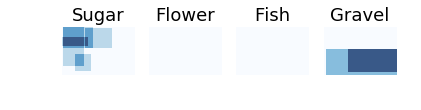

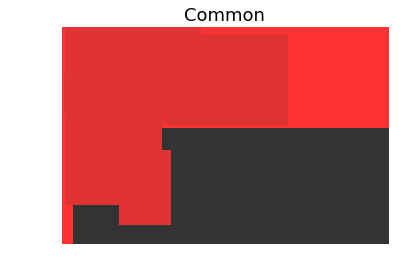

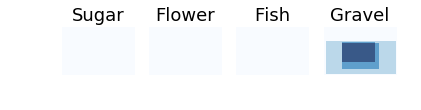

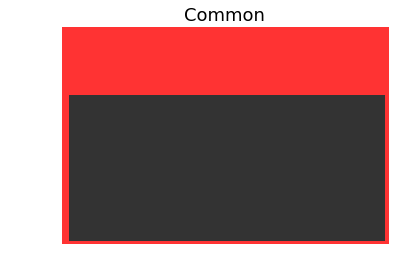

0


In [154]:
freq_arr = np.zeros((5,5))
for pair, (subject_id_pair) in enumerate(day_pairs[1:2]):
    calc_mutation_freq(subject_id_pair, fulldataset,visualize=True)
    if pair%100 == 0: print(pair)

NameError: name 'grid' is not defined

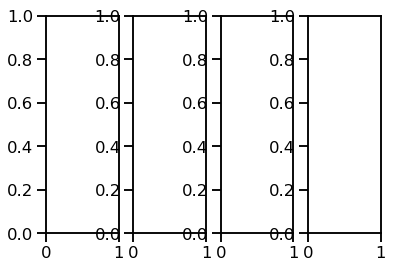

In [88]:
fig, ax = plt.subplots(1,len(pattern_dic))
for p in pattern_dic.values():
    ax[p-1].imshow(grid[:,:,p])
    ax[p-1].axis('off')

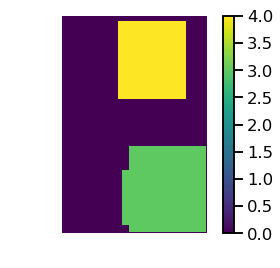

In [161]:
plt.imshow(np.argmax(grid,axis=2),vmin=0,vmax=4)
plt.colorbar()
plt.gca().axis('off');

In [81]:
pairs_evaluated = len(day_pairs)
print(np.round(freq_arr/pairs_evaluated*100,0))
print(np.sum(freq_arr/pairs_evaluated*100))

[[36.  5.  4.  6.  6.]
 [ 5.  3.  1.  1.  1.]
 [ 4.  0.  3.  1.  1.]
 [ 6.  1.  1.  2.  1.]
 [ 6.  1.  1.  1.  4.]]
99.99999662013882


In [82]:
dic = {}
pattern_dic_inv = {0: 'None', 1: 'Sugar',2: 'Flower',3: 'Fish',4: 'Gravel'}
for i,j in zip(np.indices((5,5))[0].flatten(),np.indices((5,5))[1].flatten()):
    dic[pattern_dic_inv[i]+'->'+pattern_dic_inv[j]] = np.round(freq_arr[i,j]/pairs_evaluated*100,1)
dic

{'Fish->Fish': 2.3,
 'Fish->Flower': 0.9,
 'Fish->Gravel': 1.2,
 'Fish->None': 5.9,
 'Fish->Sugar': 0.8,
 'Flower->Fish': 0.9,
 'Flower->Flower': 2.5,
 'Flower->Gravel': 0.5,
 'Flower->None': 4.0,
 'Flower->Sugar': 0.5,
 'Gravel->Fish': 1.2,
 'Gravel->Flower': 0.6,
 'Gravel->Gravel': 3.9,
 'Gravel->None': 6.0,
 'Gravel->Sugar': 1.4,
 'None->Fish': 6.0,
 'None->Flower': 3.9,
 'None->Gravel': 6.0,
 'None->None': 35.6,
 'None->Sugar': 5.3,
 'Sugar->Fish': 0.9,
 'Sugar->Flower': 0.6,
 'Sugar->Gravel': 1.5,
 'Sugar->None': 5.1,
 'Sugar->Sugar': 2.7}

In [83]:
import seaborn as sns

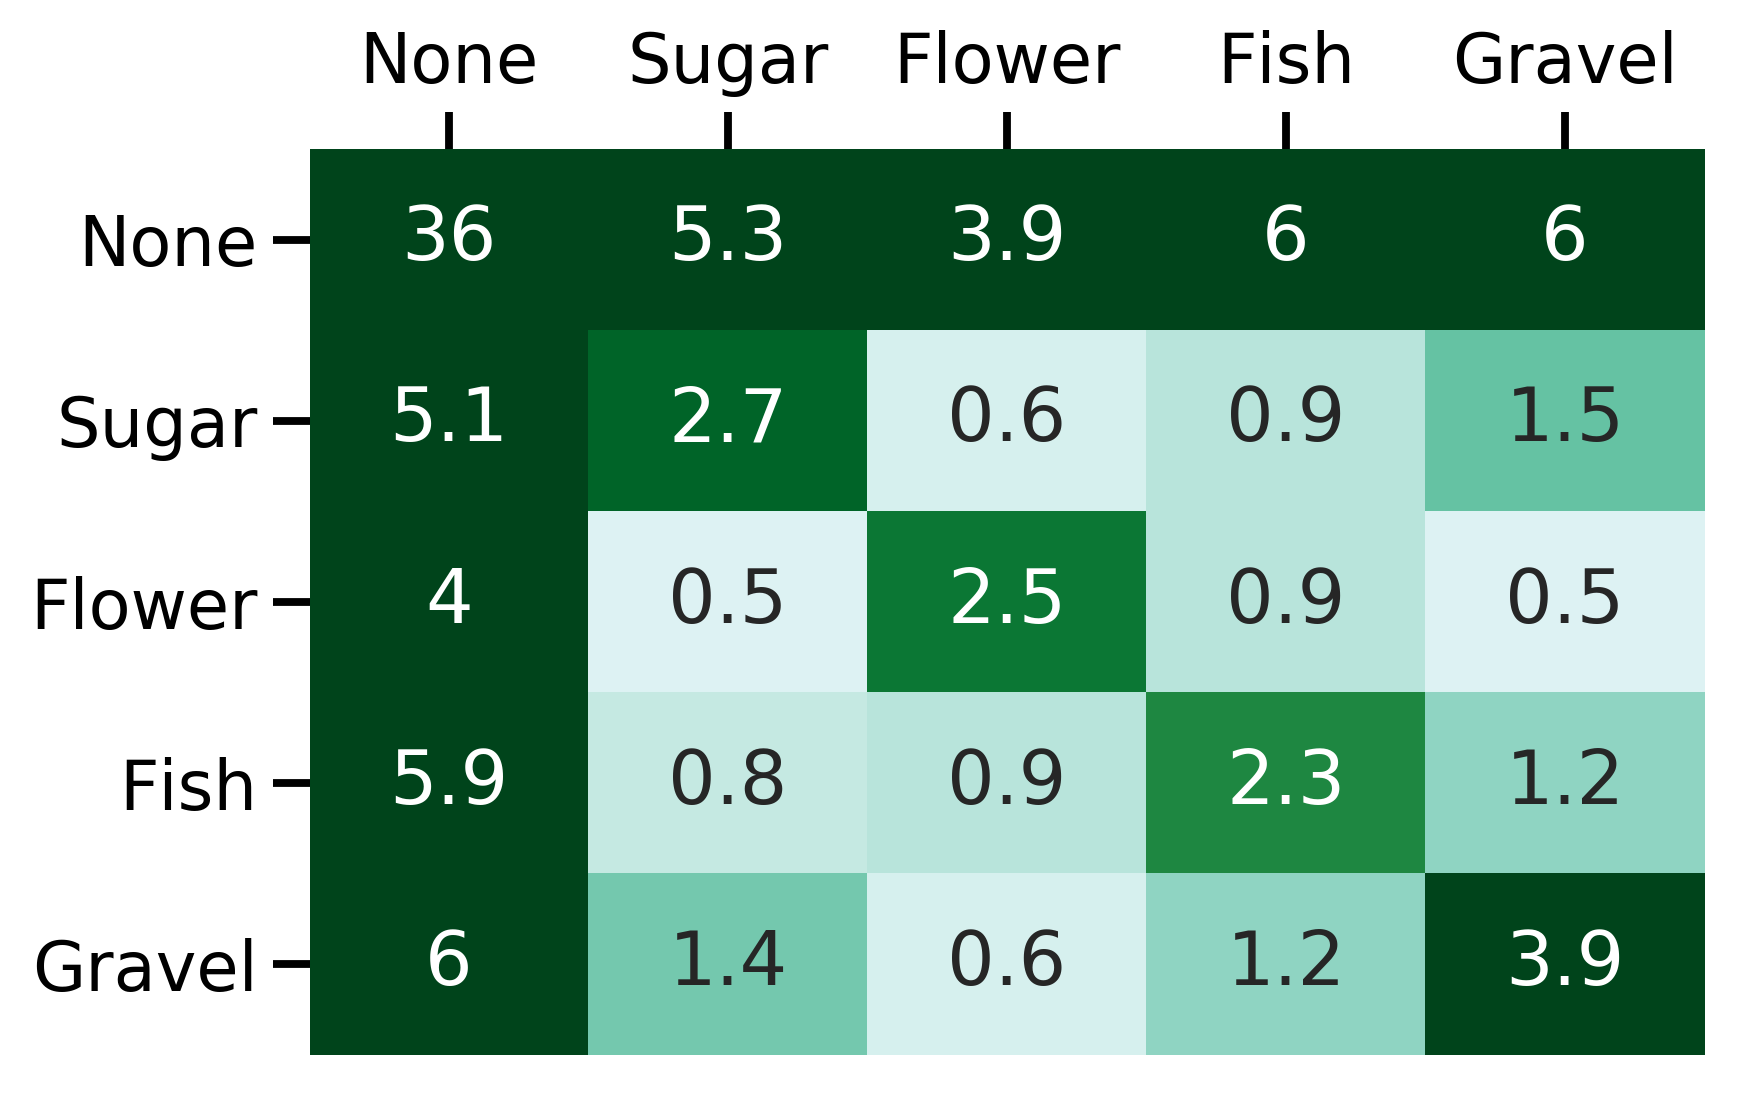

In [84]:
sns.set_context('talk')
ax = sns.heatmap(np.round(freq_arr/pairs_evaluated*100,1),annot=True,vmin=0,vmax=3,cmap='BuGn',
            cbar=False,xticklabels=pattern_dic_inv.values(),
            yticklabels=pattern_dic_inv.values());
ax.xaxis.set_ticks_position('top')
plt.gcf().set_dpi(300)

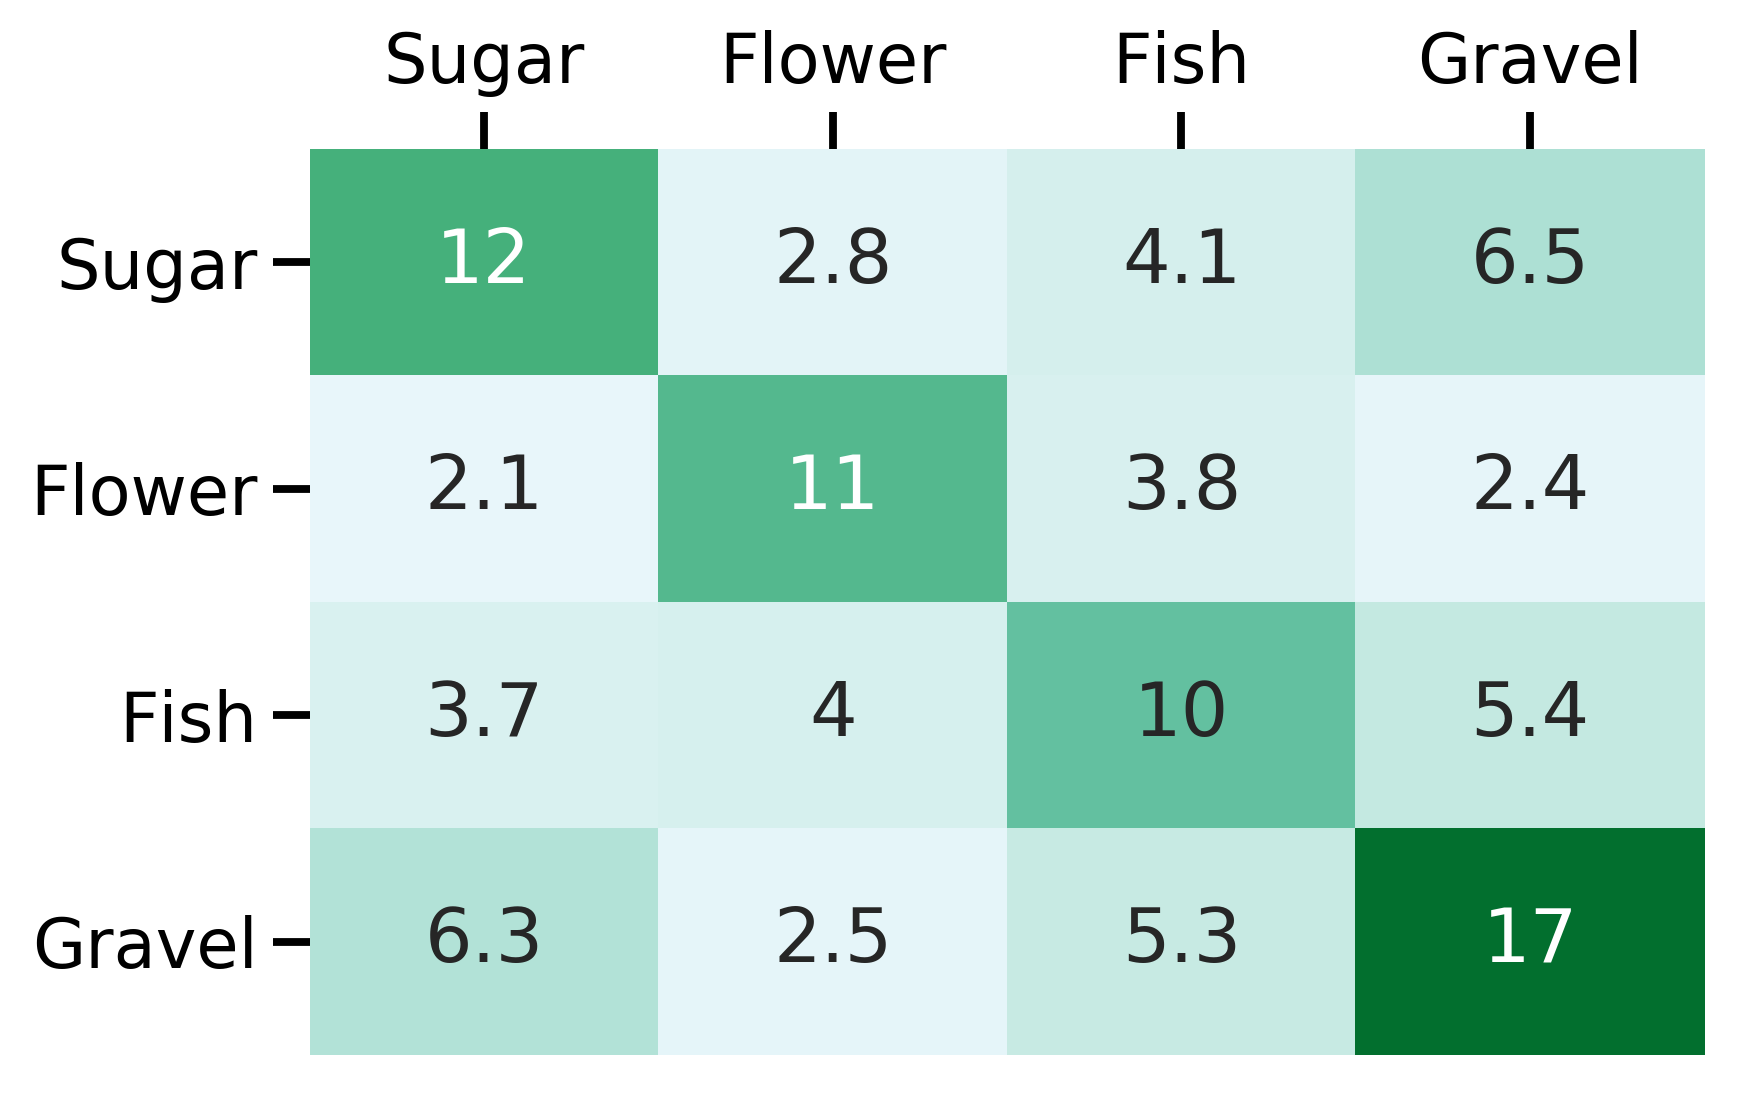

In [85]:
sns.set_context('talk')
percentage_all = freq_arr/pairs_evaluated*100
percentage_not_nones = percentage_all[1:,1:]/np.sum(percentage_all[1:,1:])*100
ax = sns.heatmap(np.round(percentage_not_nones,1),annot=True,vmin=0,vmax=20,cmap='BuGn',
            cbar=False,xticklabels=list(pattern_dic_inv.values())[1:],
            yticklabels=list(pattern_dic_inv.values())[1:]);
ax.xaxis.set_ticks_position('top')
plt.gcf().set_dpi(300)

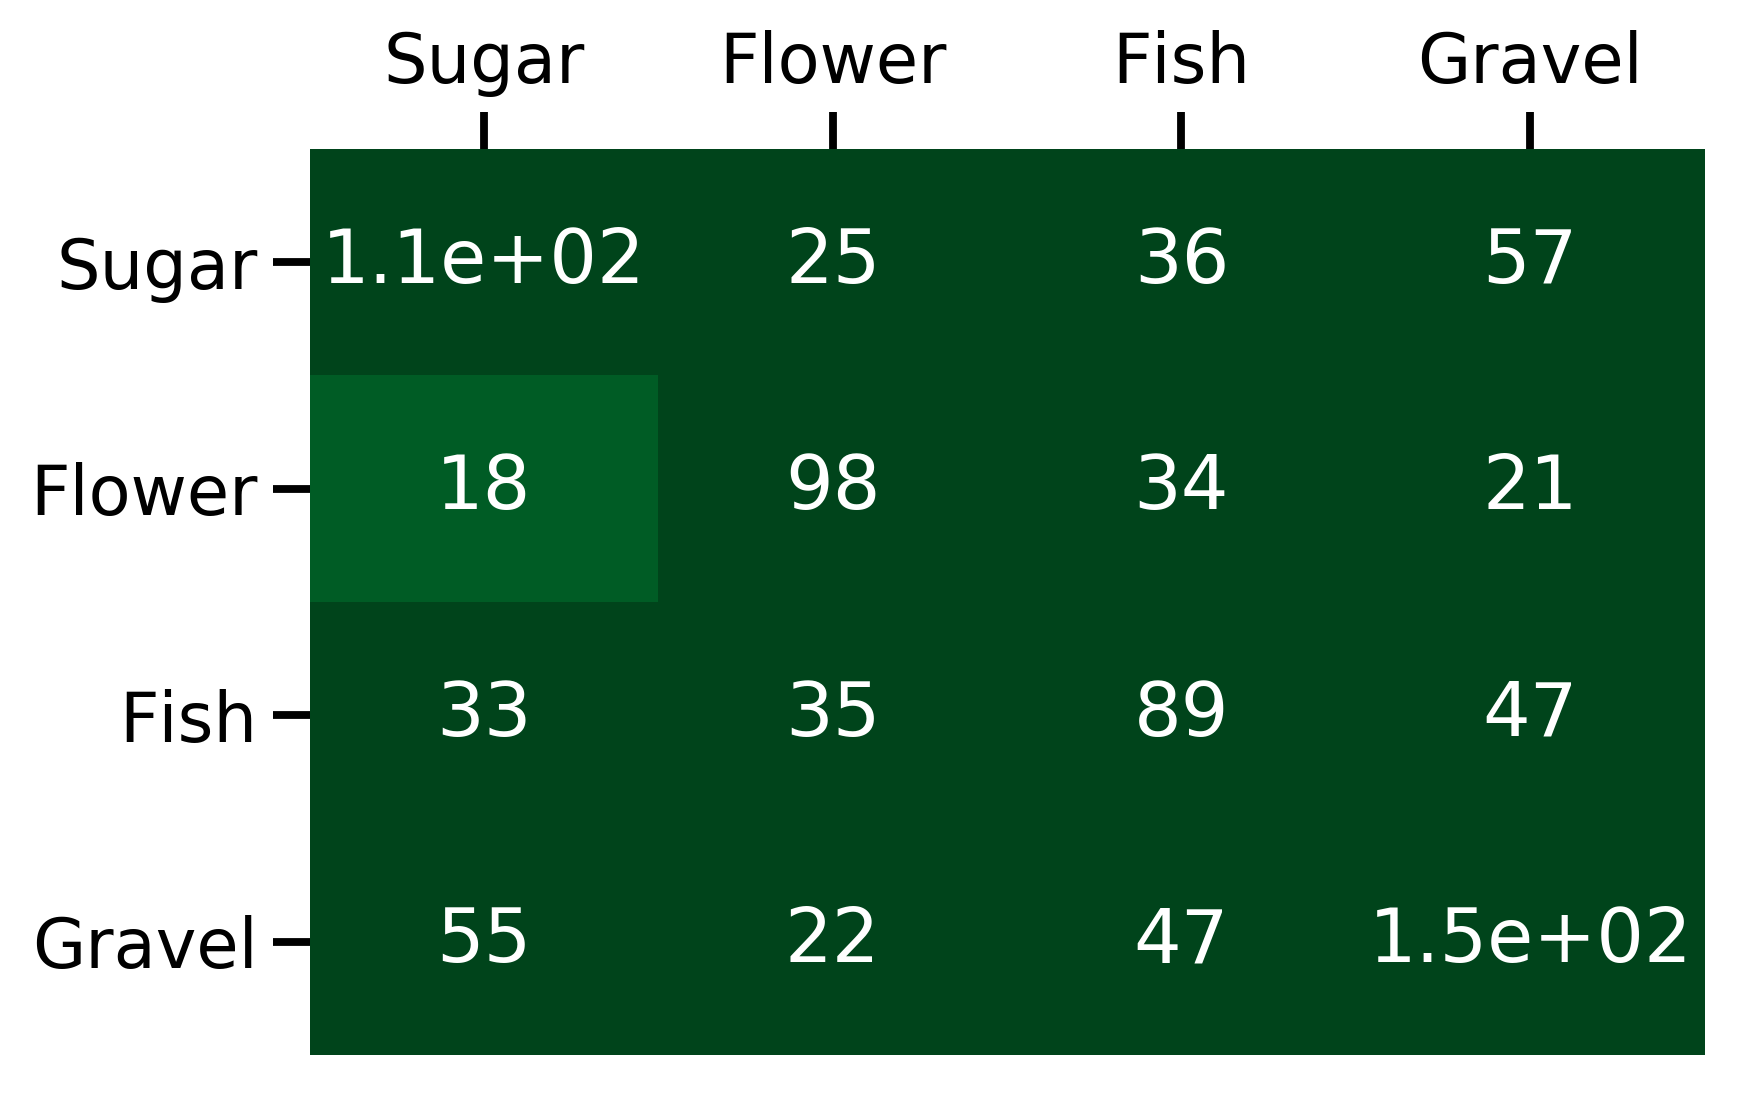

In [86]:
sns.set_context('talk')
percentage_all = freq_arr
percentage_not_nones = percentage_all[1:,1:]
ax = sns.heatmap(np.round(percentage_not_nones,1),annot=True,vmin=0,vmax=20,cmap='BuGn',
            cbar=False,xticklabels=list(pattern_dic_inv.values())[1:],
            yticklabels=list(pattern_dic_inv.values())[1:]);
ax.xaxis.set_ticks_position('top')
plt.gcf().set_dpi(300)

In [87]:
freq_arr

array([[1397.36373796,  209.08808199,  151.46980107,  233.57087893,
         234.87825235],
       [ 200.67568745,  106.66365102,   24.5773381 ,   35.89580102,
          57.22908844],
       [ 155.03640806,   18.5445585 ,   98.51725102,   33.66144082,
          21.44114898],
       [ 229.85992024,   32.71152245,   35.40487041,   89.04263776,
          47.38812959],
       [ 234.03093265,   55.40341293,   21.82061361,   46.73071021,
         151.99399186]])